In [1]:
!pip uninstall ipywidgets -y
!pip install -U ipywidgets

Found existing installation: ipywidgets 7.7.1
Uninstalling ipywidgets-7.7.1:
  Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas

In [2]:
# import desired libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# custom visualisation styling
custom = {"axes.edgecolor": "red", "grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc=custom)

import warnings
warnings.simplefilter("ignore")

In [3]:
# load datasets
train_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/test.csv")

In [4]:
# print num feats and datapoints
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (13144, 62)
Test shape :  (10000, 61)


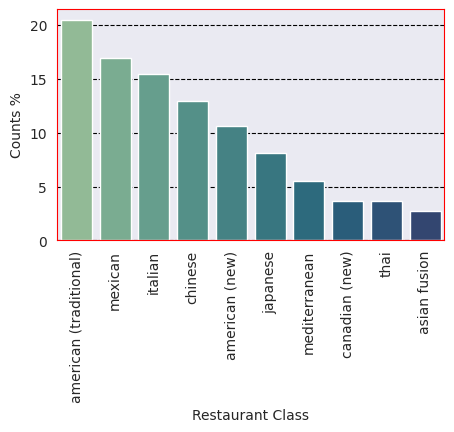

In [5]:
# check the cardinality of target distribution
rs_target = train_df['label'].value_counts(normalize=True) * 100

# target imbalance?
plt.figure(figsize=(5, 3))
sns.barplot(x=rs_target.index, y=rs_target.values, palette='crest')
plt.xlabel('Restaurant Class')
plt.xticks(rotation=90)
plt.ylabel('Counts %')
plt.show()

In [6]:
# check data-types and non-null counts of the features
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13144 entries, 0 to 13143
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     13144 non-null  int64  
 1   attributes.HappyHour                   1256 non-null   object 
 2   attributes.Ambience                    11338 non-null  object 
 3   hours.Tuesday                          10412 non-null  object 
 4   postal_code                            13144 non-null  object 
 5   attributes.AgesAllowed                 12 non-null     object 
 6   attributes.GoodForDancing              1111 non-null   object 
 7   attributes.OutdoorSeating              11845 non-null  object 
 8   hours.Saturday                         10525 non-null  object 
 9   attributes.Corkage                     182 non-null    object 
 10  longitude                              13144 non-null  float64
 11  na

In [7]:
# check missing values
train_df[['label', 'review']].isna().sum()

label     0
review    0
dtype: int64

In [8]:
# check a sample review
idx = 90
print(train_df["label"][idx], '\n')
print(train_df["review"][idx])

italian 

Great place around the corner from us. We drive by this place all the time and finally decided to go in. Pizzas were tasty and made on the spot and quickly. Will definitely be coming back. This place has a really nice modern aesthetic. I got the Pesto Toscano pizza and it was pretty good. The pizza crust is thick yet airy, with just the right amount of crunch on the exterior. The pizza would have been 5 stars if it weren't for the olives they used. I usually like olives but these olives were wayyyy too strong for the pizza. They overpowered all other flavors and that was disappointing because it was a great pizza otherwise. I would probably spring for the Margherita next time. I swung by Levetto tonight to check it out, since it\'s new to our neighbourhood. I had  the Funghi Pizza, which was delicious and an amazing value at 7$ for a "personal" size- a generous portion for one person. The toppings were super fresh and as I am a bit of a stickler for pizza crust, was happy to 

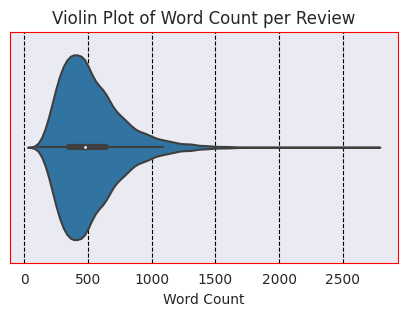

(525.5101947656725, 247.29966818641543)

In [9]:
# check review length distribution
lens = [len(review.split()) for review in train_df.review]

# calculate the statistics
plt.figure(figsize=(5,3))
sns.violinplot(x=lens)
plt.title('Violin Plot of Word Count per Review')
plt.xlabel('Word Count')
plt.show()

np.mean(lens), np.std(lens)

In [10]:
# preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

ps = PorterStemmer()
stop = set(stopwords.words('english'))

def clean_text(x, tokenise=False):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’' + '[\{\}\[\]\(\)]':
        x = x.replace(punct, '')

    tokens = x.lower().split(" ")
    tokens = [ps.stem(word) for word in tokens if word not in stop and 20>len(word)>1]

    if tokenise:
        return tokens
    
    return " ".join(tokens)

In [11]:
# apply preprocessing
# train_df["review"] = train_df["review"].apply(lambda x: clean_text(x))
# test_df["review"] = test_df["review"].apply(lambda x: clean_text(x))

In [12]:
# mapping of label to codes
mapped_classes = train_df['label'].astype('category')
hm_class = dict(enumerate(mapped_classes.cat.categories))
print(hm_class)

train_df['label'] = train_df.label.astype('category').cat.codes

# 1 hot encoding
# one_hot = pd.get_dummies(train_df['label'])
# train_df['label'] = one_hot.apply(lambda row: row.values, axis=1)

{0: 'american (new)', 1: 'american (traditional)', 2: 'asian fusion', 3: 'canadian (new)', 4: 'chinese', 5: 'italian', 6: 'japanese', 7: 'mediterranean', 8: 'mexican', 9: 'thai'}


In [13]:
# convert to huggingface dataset format
train_df = train_df[['review', 'label']]

ids_sub = test_df.id
test_df = test_df[['review']]

In [14]:
# loading a pre-trained BERT tokenizer that corresponds to the "bert-base-uncased" model.
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [15]:
from sklearn.model_selection import train_test_split

# Split train_df into 90% training and 10% validation
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=2026)

# Ensure indices are reset
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [16]:
# Tokenize function
def tokenize_texts(texts, max_length=512):
    return tokenizer(
        texts.tolist(),  # Tokenizer expects a list of strings
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors="pt"  # Return PyTorch tensors
    )

# Tokenize training and validation data
train_encodings = tokenize_texts(train_data['review'])
val_encodings = tokenize_texts(val_data['review'])
test_encodings = tokenize_texts(test_df['review'])

In [17]:
import torch
from torch.utils.data import DataLoader, Dataset

print(torch.cuda.is_available())

class TextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['label'] = torch.tensor(self.labels[idx])
        return item

# Create PyTorch dataset objects
train_dataset = TextDataset(train_encodings, train_data['label'].tolist())
val_dataset = TextDataset(val_encodings, val_data['label'].tolist())
test_dataset = TextDataset(test_encodings)

# Create DataLoader for batching and shuffling during training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

True


In [18]:
# pre-trained BERT Model
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', 
    num_labels=10, 
    hidden_dropout_prob=0.1,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10, hidden_dropout_prob=0.3)
model.to('cuda')  # Move the model to GPU if available, else keep it on CPU

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [19]:
# optimisert and loss fn
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)

In [20]:
# training the model
import torch.nn.functional as F
from sklearn.metrics import f1_score

def train(model, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = len(train_loader)

    for batch_idx, batch in enumerate(train_loader):
        # gradients tell the optimizer how to adjust the model's parameters to minimize the loss.
        # clear the gradients of all the model parameters so it doesnt accumulates gradients
        optimizer.zero_grad()

        # move the data (inputs and labels) to the GPU
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['label'].to('cuda')

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # by default its cross entropy loss
        logits = outputs.logits

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predictions and true labels for accuracy and F1 computation
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print progress every 10 batches (or modify as per your need)
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{num_batches}, Loss: {loss.item():.4f}")


    # Calculate average loss
    avg_loss = total_loss / len(train_loader)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Epoch {epoch}, Loss: {avg_loss}, Accuracy: {accuracy}, F1 Score: {f1}')

In [21]:
# evaluate
def evaluate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    # you do not need to compute gradients
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['label'].to('cuda')

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            # Convert logits to probabilities using softmax
            probabilities = F.softmax(logits, dim=-1)

            total_loss += loss.item()

            # Store predictions and true labels for accuracy and F1 computation
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = total_loss / len(val_loader)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Validation Loss: {avg_loss}, Accuracy: {accuracy}, F1 Score: {f1}')
    return avg_loss, accuracy, f1

In [22]:
# Early stopping parameters
patience = 1  # Number of epochs to wait before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop for 3 epochs
for epoch in range(3):
    print(f"Training epoch {epoch + 1}...")
    train(model, train_loader, optimizer, epoch)
    print("Evaluating on validation set...")
    val_loss, accuracy, f1 = evaluate(model, val_loader)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        print(f"Validation loss improved: {val_loss}")
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Epochs without improvement: {epochs_without_improvement}")
        
    if epochs_without_improvement >= patience:
        print("Early stopping triggered")
        break

Training epoch 1...
Epoch 0, Batch 0/370, Loss: 2.2791
Epoch 0, Batch 50/370, Loss: 1.6202
Epoch 0, Batch 100/370, Loss: 0.8828
Epoch 0, Batch 150/370, Loss: 0.7501
Epoch 0, Batch 200/370, Loss: 0.5645
Epoch 0, Batch 250/370, Loss: 0.5420
Epoch 0, Batch 300/370, Loss: 0.4919
Epoch 0, Batch 350/370, Loss: 0.5925
Epoch 0, Loss: 0.9279326579860738, Accuracy: 0.6987065686025868, F1 Score: 0.6694281102562847
Evaluating on validation set...
Validation Loss: 0.6044724590721584, Accuracy: 0.8022813688212928, F1 Score: 0.7762261724379249
Validation loss improved: 0.6044724590721584
Training epoch 2...
Epoch 1, Batch 0/370, Loss: 0.7974
Epoch 1, Batch 50/370, Loss: 0.2608
Epoch 1, Batch 100/370, Loss: 0.6014
Epoch 1, Batch 150/370, Loss: 0.6209
Epoch 1, Batch 200/370, Loss: 0.6686
Epoch 1, Batch 250/370, Loss: 0.2786
Epoch 1, Batch 300/370, Loss: 0.4151
Epoch 1, Batch 350/370, Loss: 0.4798
Epoch 1, Loss: 0.5611219872896736, Accuracy: 0.8086059683827881, F1 Score: 0.79803871108008
Evaluating on v

In [23]:
def test(model, test_loader):
    model.eval()
    predictions = []
    probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Convert logits to probabilities
            probabilities = F.softmax(logits, dim=-1)

            # Get predictions
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            probs.extend(probabilities.cpu().numpy())  # Collect probabilities for each sample

    return predictions, probs

# Get predictions on the test set
test_predictions, test_probs = test(model, test_loader)

In [24]:
# Create a DataFrame from the predicted probabilities
_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/test.csv")
df_roberta_probs = pd.DataFrame(test_probs, columns=[f'prob_class_{i+1}' for i in range(10)])

# Save the DataFrame to a CSV file
submission = pd.DataFrame({'Id' : _df.id}, columns = ['Id'])

# Combine the 'Id' column with the predicted probabilities
df_roberta_probs = pd.concat([submission, df_roberta_probs], axis=1)

df_roberta_probs.to_csv('test_y_pred_robert.csv', index=False)

In [25]:
# revert the integer labels back to string labels using the encoder's inverse_transform method
predicted_string_labels = list(map(hm_class.get, test_predictions))

In [26]:
# clearly our submissions are evaluated on the basis of F1Score
submission = pd.DataFrame({'Id' : _df.id}, columns = ['Id'])
submission['Predicted'] = predicted_string_labels
submission.to_csv('predicted.csv', index=False)